<a href="https://colab.research.google.com/github/ntshtn/Tensorflow_Deep_Learning/blob/main/10_time_series_forecasting_with_tensorflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Time series forecasting fundamentals with TensorFlow + Milestone Project 3: BitPredict

Let's write some TensorFlow code to predict the price of Bitcoin based on the historical price of Bitcoin.

⚠️ **Note:** This is not a financial advice.

The predictability of an event or a quantity depends on several factors:
1. how well we understand the factors that contribute to it,
2. how much data is available,
3. how similar the future is to the past,
4. whether the forecasts can affect the thing we are trying to forecast.

## Get Data

The data is from: https://www.coindesk.com/price/bitcoin, and we will be using the closing price of 24 hours.

In [1]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv

--2025-02-25 19:21:18--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 178509 (174K) [text/plain]
Saving to: ‘BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv’

BTC_USD_2013-10-01_ 100%[===================>] 174.33K  --.-KB/s    in 0.02s   

2025-02-25 19:21:18 (8.53 MB/s) - ‘BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv’ saved [178509/178509]



## Importing time series data with pandas

In [2]:
# Import with pandas
import pandas as pd
# Let's read in our Bitcoin data and parse the dates
df = pd.read_csv("/content/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv", parse_dates=["Date"], index_col=["Date"]) # parse the data column and tell pandas that the first column is a date

df.head()

,Currency,Closing Price (USD),24h Open (USD),24h High (USD),24h Low (USD)
Date,,,,,
2013-10-01,BTC,123.65499,124.30466,124.75166,122.56349
2013-10-02,BTC,125.45500,123.65499,125.75850,123.63383
2013-10-03,BTC,108.58483,125.45500,125.66566,83.32833
2013-10-04,BTC,118.67466,108.58483,118.67500,107.05816
2013-10-05,BTC,121.33866,118.67466,121.93633,118.00566


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2787 entries, 2013-10-01 to 2021-05-18
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Currency             2787 non-null   object 
 1   Closing Price (USD)  2787 non-null   float64
 2   24h Open (USD)       2787 non-null   float64
 3   24h High (USD)       2787 non-null   float64
 4   24h Low (USD)        2787 non-null   float64
dtypes: float64(4), object(1)
memory usage: 130.6+ KB


In [4]:
df.tail()

,Currency,Closing Price (USD),24h Open (USD),24h High (USD),24h Low (USD)
Date,,,,,
2021-05-14,BTC,49764.132082,49596.778891,51448.798576,46294.720180
2021-05-15,BTC,50032.693137,49717.354353,51578.312545,48944.346536
2021-05-16,BTC,47885.625255,49926.035067,50690.802950,47005.102292
2021-05-17,BTC,45604.615754,46805.537852,49670.414174,43868.638969
2021-05-18,BTC,43144.471291,46439.336570,46622.853437,42102.346430


In [5]:
len(df)

2787

We've collected the historical price of Bitcoin for the past ~8 years but there's 2787 samples.

Typically deep learning models like lots and lots of samples (where lots can thousands to tens of thousand to millions).

A smaller number of samples is something we will run into with time series data problems.

> **Note:** The **seasonality** of a time series dataset is referred as the number of samples per year. So for our Bitcoin data, it has a seasonality of daily value of 365 because we collect one sample per day.

### Types of time series

* **Trend:** time series has a clear long-termn increase or decrease (may or may not be linear).
* **Seasonal:** time series affected by seasonal factors such as time of the year (e.g. increased sales towards end of year).
* **Cyclic:** time series shows rises and falls over an unfixed period, these tend to be longer/more variable than seasonal pattern.

### Univariate and Multivariate time series data

* **Univariate:** Only one variable (using the price of Bitcoin to predict the price of Bitcoin).
* **Multivariate:** More than one variable (using the price of Bitcoin as well as the block reward size to predict the price of Bitcoin).

In [6]:
## Extract only the data we wanted

In [7]:
# Only want closing price for each day
bitcoin_prices = pd.DataFrame(df["Closing Price (USD)"]).rename(columns={"Closing Price (USD)": "Price"})
bitcoin_prices.head()

,Price
Date,
2013-10-01,123.65499
2013-10-02,125.45500
2013-10-03,108.58483
2013-10-04,118.67466
2013-10-05,121.33866


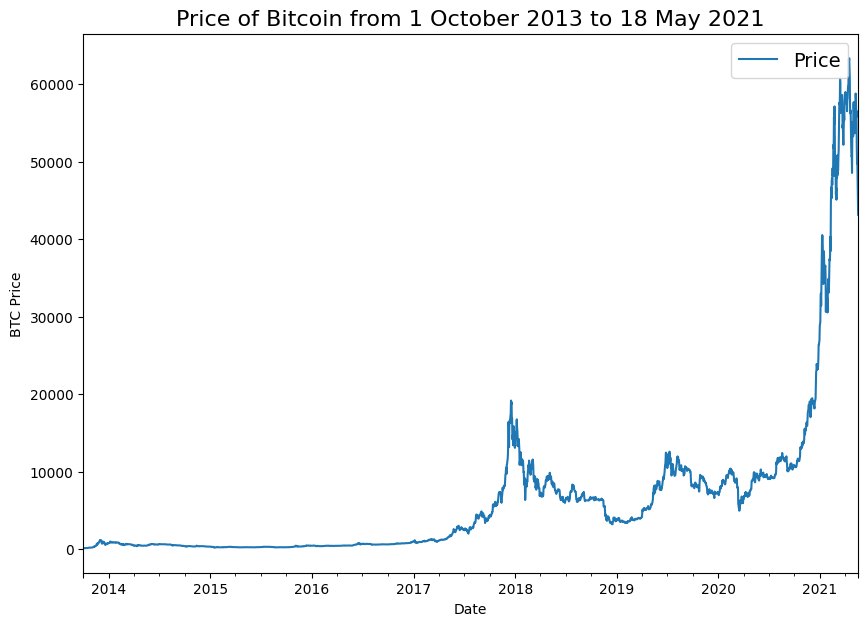

In [8]:
import matplotlib.pyplot as plt
bitcoin_prices.plot(figsize=(10,7))
plt.ylabel("BTC Price")
plt.title("Price of Bitcoin from 1 October 2013 to 18 May 2021", fontsize=16)
plt.legend(fontsize=14);

## Importing time series data with Python's CSV module

In [9]:
# Importing and formatting historical Bitcoin data with Python
import csv
from datetime import datetime

timesteps = []
btc_price = []
with open("/content/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv", "r") as f:
  csv_reader = csv.reader(f, delimiter=",")
  next(csv_reader) # skip first line (get rid of column titles)
  for line in csv_reader:
    timesteps.append(datetime.strptime(line[1], "%Y-%m-%d")) # get the dates as dates (not as strings)
    btc_price.append(float(line[2])) # get the closing price as float

# View first 10 of each
timesteps[:10], btc_price[:10]

([datetime.datetime(2013, 10, 1, 0, 0),
  datetime.datetime(2013, 10, 2, 0, 0),
  datetime.datetime(2013, 10, 3, 0, 0),
  datetime.datetime(2013, 10, 4, 0, 0),
  datetime.datetime(2013, 10, 5, 0, 0),
  datetime.datetime(2013, 10, 6, 0, 0),
  datetime.datetime(2013, 10, 7, 0, 0),
  datetime.datetime(2013, 10, 8, 0, 0),
  datetime.datetime(2013, 10, 9, 0, 0),
  datetime.datetime(2013, 10, 10, 0, 0)],
 [123.65499,
  125.455,
  108.58483,
  118.67466,
  121.33866,
  120.65533,
  121.795,
  123.033,
  124.049,
  125.96116])

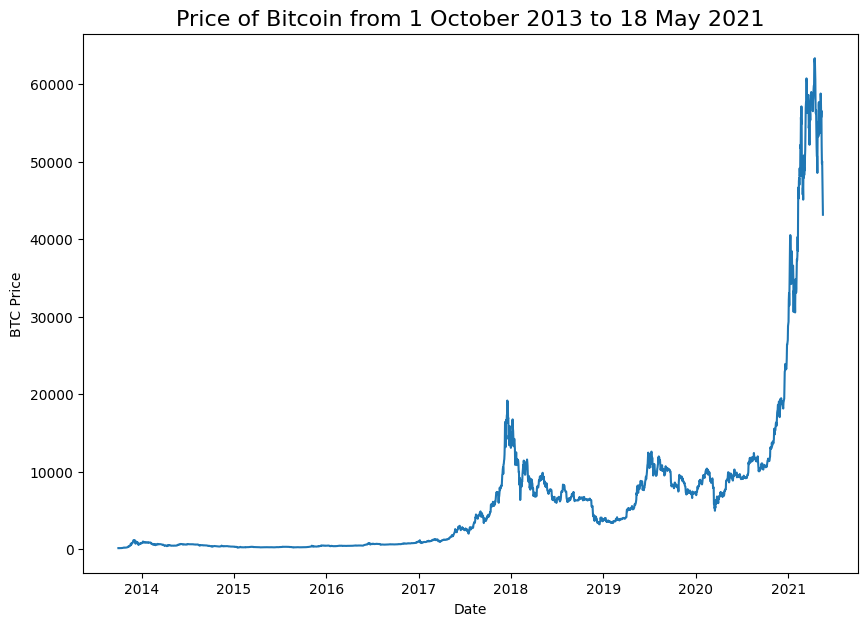

In [10]:
# Plot from csv
import matplotlib.pyplot as plt
import numpy as np
plt.figure(figsize=(10,7))
plt.plot(timesteps, btc_price)
plt.ylabel("BTC Price")
plt.xlabel("Date")
plt.title("Price of Bitcoin from 1 October 2013 to 18 May 2021", fontsize=16);
#plt.legend() doesn't work for data from python csv

## Format data part 1: Create train and test sets of our time series data

### Creating train and test sets with time series data (The **WRONG** way)

In [11]:
# Get bitcoin date array
timesteps = bitcoin_prices.index.to_numpy()
prices = bitcoin_prices["Price"].to_numpy()

timesteps[:10], prices[:10]

(array(['2013-10-01T00:00:00.000000000', '2013-10-02T00:00:00.000000000',
        '2013-10-03T00:00:00.000000000', '2013-10-04T00:00:00.000000000',
        '2013-10-05T00:00:00.000000000', '2013-10-06T00:00:00.000000000',
        '2013-10-07T00:00:00.000000000', '2013-10-08T00:00:00.000000000',
        '2013-10-09T00:00:00.000000000', '2013-10-10T00:00:00.000000000'],
       dtype='datetime64[ns]'),
 array([123.65499, 125.455  , 108.58483, 118.67466, 121.33866, 120.65533,
        121.795  , 123.033  , 124.049  , 125.96116]))

In [12]:
# Wrong way to make train/test set for time series data
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(timesteps, prices, test_size=0.2, random_state=42)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((2229,), (558,), (2229,), (558,))

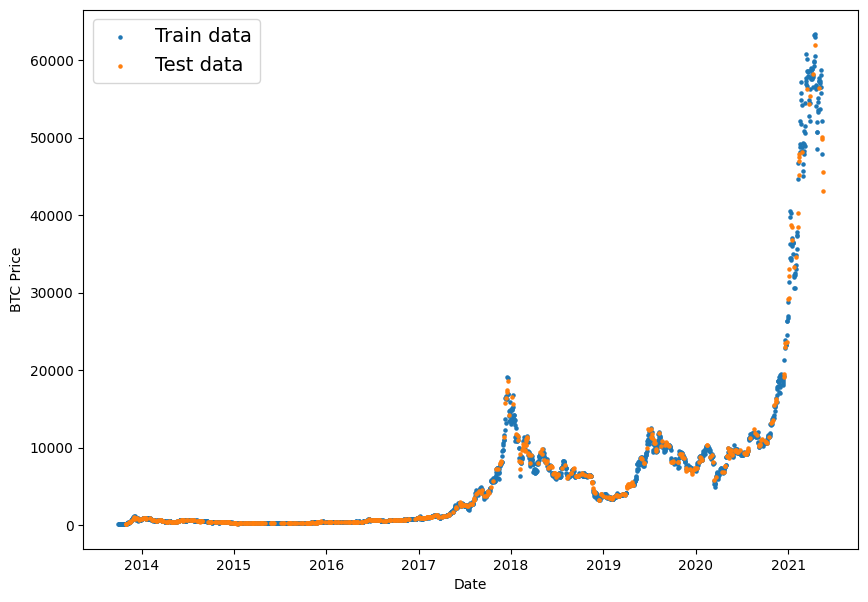

In [13]:
# Let's plot wrong train and test splits
plt.figure(figsize=(10,7))
plt.scatter(X_train, y_train, s=5, label="Train data")
plt.scatter(X_test, y_test, s=5, label="Test data")
plt.xlabel("Date")
plt.ylabel("BTC Price")
plt.legend(fontsize=14)
plt.show();

The issue with this is that it is a random split, our training data set is riddled with test data, which is a data leak. Data from the (pseudo) future leaks into past.

### Create train and test sets for time series (the right way)

We use time series split to create train set that represents the past, and test set that represents the (pseudo) future.

In [14]:
# Create train and test splits the right way for time series data
split_size = int(0.8 * len(prices)) # 80% train, 20% test

# Create train data splits (everything before the split)
X_train, y_train = timesteps[:split_size], prices[:split_size]

# Create test data splits (everything beyond the split)
X_test, y_test = timesteps[split_size:], prices[split_size:]

len(X_train), len(X_test), len(y_train), len(y_test)

(2229, 558, 2229, 558)

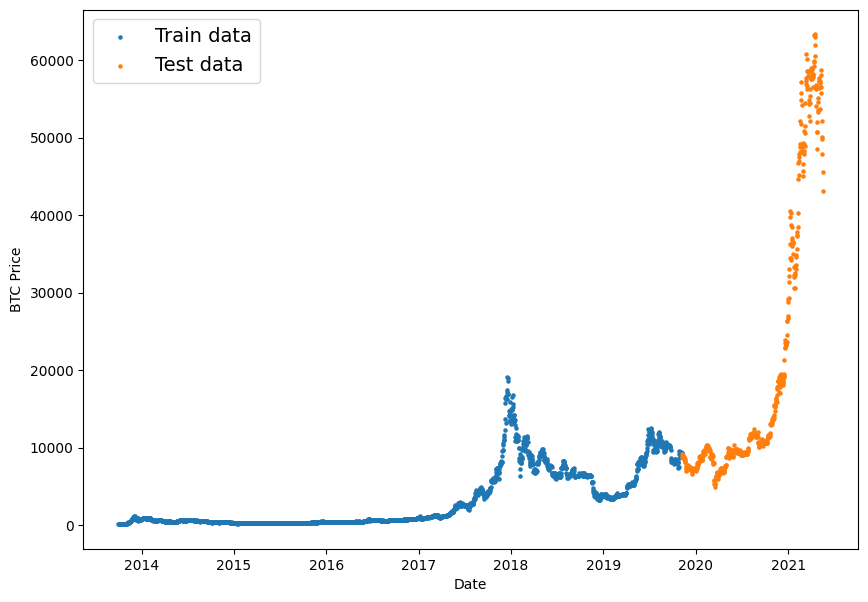

In [15]:
# Plot correctly made splits
plt.figure(figsize=(10,7))
plt.scatter(X_train, y_train, s=5, label="Train data")
plt.scatter(X_test, y_test, s=5, label="Test data")
plt.xlabel("Date")
plt.ylabel("BTC Price")
plt.legend(fontsize=14)
plt.show();

## Create a plotting function

Typing plotting code is tedious, let's functionize it.

In [16]:
# Create a function to plot time series data
def plot_time_series(timesteps, values, format=".", start=0, end=None, label=None):
  """
  Plots timesteps (a series of points in time) against values (a series of values across timesteps).

  Parameters
  ----------
  timesteps : array of timestep values
  values : array of values across time
  format : style of plot, default "."
  start : where to start the plot (setting a values will index from start of timesteps and values)
  end :  where to end the plot (similar to start but for the end)
  label : label to show on plot about values, default None
  """
  plt.plot(timesteps[start:end], values[start:end], format, label=label)
  plt.xlabel("Time")
  plt.ylabel("BTC Price")
  if label:
    plt.legend(fontsize=14)
  plt.grid(True)

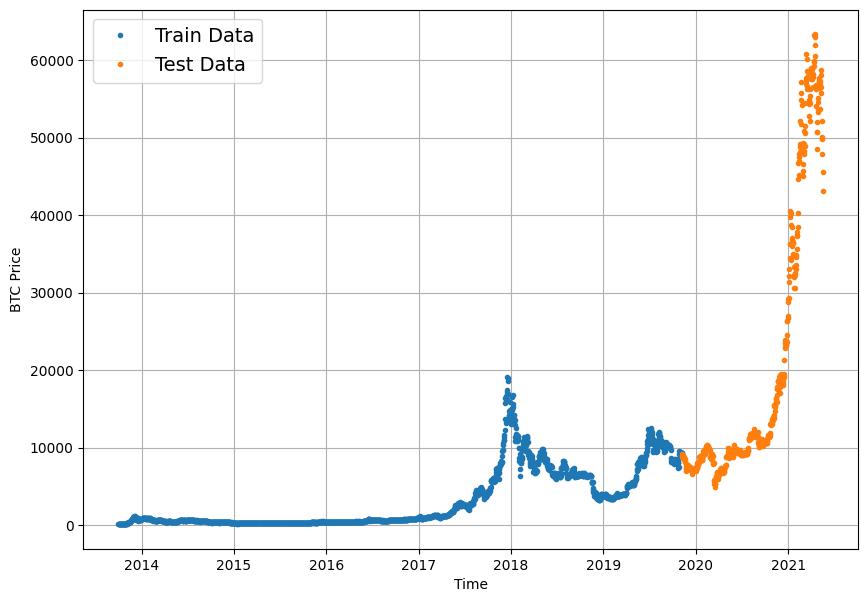

In [17]:
# Testing out plotting function
plt.figure(figsize=(10,7))
plot_time_series(timesteps=X_train, values=y_train, label="Train Data")
plot_time_series(timesteps=X_test, values=y_test, label="Test Data")

## Modelling Experiments

We've got some Bitcoin historical data, to model it, let's run a series of modelling experiments and see which model performs best.

Terms to be familiar with:
* **Horizon** = number of timesteps into the future we're going to predict
* **Window size** = number of timesteps we're going to use to predict horizon

The experiments:

0 - Naïve model (baseline)

1 - Dense model (horizon=1, window=7)

2 - Same as model 1 (horizon=1, window=30)

3 - Same as model (horizon=7, window=30)

4 - Conv1D (horizon=1, window=7)

5 - LSTM (RNN) (horizon=1, window=7)

6 - Same as model 1 (but with multivariate data) (horizon=1, window=7)

7 - N-BEATS algorithmn (horizon=1, window=7)

8 - Ensemble (horizon=1, window=7)

9 - Future prediction model (horizon=1, window=7)

10 - Same as model 1 (but with turkey data introduced) (horizon=1, window=7)

## Model 0: Naïve forecast

The formula looks like this:
$$\hat{y}_{t} = y_{t-1}$$

The prediction at timestep t (y-hat) is equal to the value at timestep t-1 (previous timestep) - this is for a horizon of 1.

**Ressource:** https://otexts.com/fpp3/simple-methods.html

In [18]:
# Create a naive forecast
naive_forecast = y_test[:-1]

naive_forecast[:10], naive_forecast[-10:]

(array([9226.48582088, 8794.35864452, 8798.04205463, 9081.18687849,
        8711.53433917, 8760.89271814, 8749.52059102, 8656.97092235,
        8500.64355816, 8469.2608989 ]),
 array([57107.12067189, 58788.20967893, 58102.19142623, 55715.54665129,
        56573.5554719 , 52147.82118698, 49764.1320816 , 50032.69313676,
        47885.62525472, 45604.61575361]))

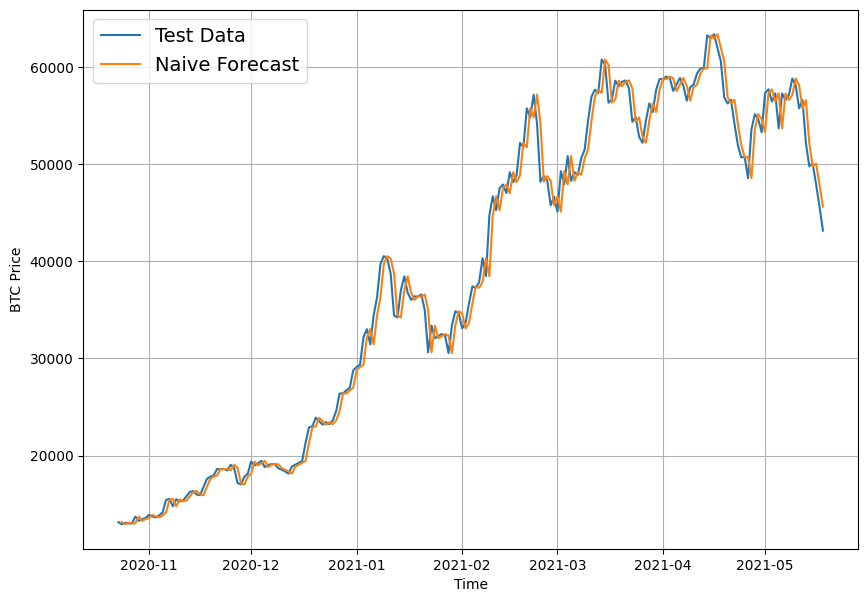

In [19]:
# Plot naive forecast
plt.figure(figsize=(10,7))
#plot_time_series(timesteps=X_train, values=y_train, label="Train Data")
plot_time_series(timesteps=X_test, values=y_test, format="-", start=350, label="Test Data")
plot_time_series(timesteps=X_test[1:], values=naive_forecast, format="-", start=350, label="Naive Forecast")

## Evaluating a time series model

Let's look into some evaluation metrics for time series forecasting.

We are predicting a number, so that means we have a form of a regression problem and we'll need some regression-like metrics.

A few common regression metrics (which can also be used for time series forecasting):
* MAE - mean absolute error
* MSE - mean squared error
* RMSE - root mean squared error
* MAPE/sMAPE - (symmetric) mean absolute percentage error
* MASE - mean absolute scaled error

For all the above metrics, lower is better.

The main thing we're evaluating here is: how do our model's forecast (y_pred) compare against the actual values (y_true or ground truth values)?

**Resource:** https://otexts.com/fpp3/accuracy.html

In [20]:
import tensorflow as tf

In [21]:
# MASE implementation
def mean_absolute_scaled_error(y_true, y_pred):
  """
  Implement MASE (assuming no seasonality of data).
  """
  mae = tf.reduce_mean(tf.abs(y_true-y_pred))

  # Find MAE of naive forecast (no seasonality)
  mae_naive_no_season = tf.reduce_mean(tf.abs(y_true[1:] - y_true[:-1])) # our seasonality is 1 day (hence the shift of 1)

  return mae / mae_naive_no_season

In [22]:
mean_absolute_scaled_error(y_true=y_test[1:], y_pred=naive_forecast).numpy()

0.9995699939182624

In [23]:
# Create a function to take in model predictions and truth values and return evaluation metrics
def evaluate_pred(y_true, y_pred):
  # Make sure float32 datatype (for metric calculation)
  y_true = tf.cast(y_true, dtype=tf.float32)
  y_pred = tf.cast(y_pred, dtype=tf.float32)

  # Calculate various evaluation metrics
  mae = tf.keras.metrics.mae(y_true, y_pred)
  mse = tf.keras.metrics.mse(y_true, y_pred)
  rmse = tf.sqrt(mse)
  mape = tf.keras.metrics.mape(y_true, y_pred)
  mase = mean_absolute_scaled_error(y_true, y_pred)

  return {"mae": mae.numpy(),
          "mse": mse.numpy(),
          "rmse": rmse.numpy(),
          "mape": mape.numpy(),
          "mase": mase.numpy()}

In [24]:
naive_results = evaluate_pred(y_true=y_test[1:], y_pred=naive_forecast)
naive_results

{'mae': 567.9802,
 'mse': 1147547.0,
 'rmse': 1071.2362,
 'mape': 2.5165248,
 'mase': 0.99957}

## Format Data Part 2: Windowing our dataset

We window our time series dataset to turn our data into supervised learning problem.

```
Windowing for one week
[0, 1, 2, 3, 4, 5, 6] -> [7]
[1, 2, 3, 4, 5, 6, 7] -> [8]
[2, 3, 4, 5, 6, 7, 8] -> [9]
```

**Resource (Sliding vs. Expanding Windows):** https://www.uber.com/en-DE/blog/forecasting-introduction/

In [25]:
# What we want to do with our Bitcoin data
print(f"We want to use: {btc_price[:7]} to predict this: {btc_price[7]}")

We want to use: [123.65499, 125.455, 108.58483, 118.67466, 121.33866, 120.65533, 121.795] to predict this: 123.033


In [26]:
# Setup global variables for window and horizon sizes
HORIZON = 1 # predict next 1 day
WINDOW_SIZE = 7 # use the past week of Bitcoin data to make the predictions

In [27]:
# Create function to label windowed data
def get_labelled_windows(x, horizon=HORIZON):
  """
  Create labels for windowed dataset.

  E.g. if horizon = 1
  Input: [0, 1, 2, 3, 4, 5, 6, 7] -> Output: ([0, 1, 2, 3, 4, 5, 6], 7)
  """
  return x[:, :-horizon], x[:, -horizon:]

In [28]:
# Test out the window labelling function
test_window, test_label = get_labelled_windows(tf.expand_dims(tf.range(8), axis=0))
print(f"Window: {tf.squeeze(test_window).numpy()} -> Label: {tf.squeeze(test_label).numpy()}")

Window: [0 1 2 3 4 5 6] -> Label: 7


We need a way to do the above (which is only for small scale data) across our entire time series.

We could do this with Python for loops, however, for large time series, that'd be quite slow.

To speed things up, we'll leverage NumPy's array indexing.

Our function will:
1. Create a window step of specific window size.
2. Use NumPy indexing to create a 2D array of multiple window steps, for example:
```
[[0, 1, 2, 3, 4, 5, 6],
[1, 2, 3, 4, 5, 6, 7],
[2, 3, 4, 5, 6, 7, 8]]
```
3. Uses the 2D array of multiple window steps to index on a target series (e.g. the historical price of Bitcoin).
4. Uses the `get_labelled_windows()` function we created above to turn the window steps with specified horizon.

**Resource:** The function we want to create has been adapted from the following article: https://medium.com/towards-data-science/fast-and-robust-sliding-window-vectorization-with-numpy-3ad950ed62f5

In [29]:
# Create function to view NumPy arrays as windows
def make_windows(x, window_size=WINDOW_SIZE, horizon=HORIZON):
  """
  Turns a 1D array into a 2D array of sequential labelled window_size with horizon size labels.
  """
  # 1. Create a window of a specific window_size (add the horizon on the end for labelling later)
  window_step = np.expand_dims(np.arange(window_size + horizon), axis=0)
  print(window_step)
  # 2. Create a 2D array of multiple window steps (minum 1 to account for 0 indexing)
  window_indexes = window_step + np.expand_dims(np.arange(len(x) - (window_size + horizon - 1)), axis=0).T # create 2D array of windows of window_size
  print(window_indexes)
  # 3. Index on the target array (a time series) with 2D array of multiple window steps
  windowed_array = x[window_indexes]
  # 4. Get the labelled windows
  windows, labels = get_labelled_windows(windowed_array, horizon=horizon)
  return windows, labels


In [30]:
full_windows, full_labels = make_windows(prices)

[[0 1 2 3 4 5 6 7]]
[[   0    1    2 ...    5    6    7]
 [   1    2    3 ...    6    7    8]
 [   2    3    4 ...    7    8    9]
 ...
 [2777 2778 2779 ... 2782 2783 2784]
 [2778 2779 2780 ... 2783 2784 2785]
 [2779 2780 2781 ... 2784 2785 2786]]


In [31]:
# View the first 3 windows/labels
for i in range(3):
  print(f"Window: {full_windows[i]} -> Label: {full_labels[i]}")

Window: [123.65499 125.455   108.58483 118.67466 121.33866 120.65533 121.795  ] -> Label: [123.033]
Window: [125.455   108.58483 118.67466 121.33866 120.65533 121.795   123.033  ] -> Label: [124.049]
Window: [108.58483 118.67466 121.33866 120.65533 121.795   123.033   124.049  ] -> Label: [125.96116]


In [32]:
# View the last 3 windows/labels
for i in range(3):
  print(f"Window: {full_windows[i-3]} -> Label: {full_labels[i-3]}")

Window: [58788.20967893 58102.19142623 55715.54665129 56573.5554719
 52147.82118698 49764.1320816  50032.69313676] -> Label: [47885.62525472]
Window: [58102.19142623 55715.54665129 56573.5554719  52147.82118698
 49764.1320816  50032.69313676 47885.62525472] -> Label: [45604.61575361]
Window: [55715.54665129 56573.5554719  52147.82118698 49764.1320816
 50032.69313676 47885.62525472 45604.61575361] -> Label: [43144.47129086]


> **Note:** We can find a function which achieves similar reasults to the ones we implemented above at `tf.keras.preprocessing.timeseries_dataset_from_array()`. It takes an array and returns a windowed dataset. It has the benefit of returning data in the form of tf.data.Dataset instance. https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/timeseries_dataset_from_array

## Turning windows into training and test sets


In [33]:
# Make the train/test splits
def make_train_test_split(windows, labels, test_split=0.2):
  """
  Split matching pairs of windows and labels into train and test splits.
  """
  split_size = int(len(windows) * (1-test_split)) # this will default to 80% train and 20% test
  train_windows = windows[:split_size]
  train_labels = labels[:split_size]
  test_windows = windows[split_size:]
  test_labels = labels[split_size:]
  return train_windows, test_windows, train_labels, test_labels

In [34]:
# Create train and test windows
train_windows, test_windows, train_labels, test_labels = make_train_test_split(full_windows, full_labels)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(2224, 556, 2224, 556)

In [35]:
# Check to see if train labels are the same (before and after window split)
np.array_equal(np.squeeze(train_labels[:-HORIZON-1]), y_train[WINDOW_SIZE:])

True

## Make a modelling checkpoint callback

Because our model's performance will fluctuate from experiment to experiment, we're going to write a model checkpoint so we can compare apples to apples.

More specifically, we want to compare each of our model's best performance against other model's best performance.

For example if our model performs best on epoch 55 (but we're training for 100 epochs), we want to load and evaluate the model saved on epoch 55.

We can create a modelling checkpoint callback using the following: https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ModelCheckpoint

In [36]:
import os

# Create a function to implement a ModelCheckpoint callback with a specific filename
def create_model_checkpoint(model_name, save_path="model_experiments"):
  return tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(save_path, model_name) + ".keras",
                                            verbose=0,
                                            save_best_only=True)

## Model 1: Dense Model (Window = 7, Horizon = 1)

Our first deep model is going to be a simple dense model:
* A single dense layer with 128 hidden units and ReLU
* An output layer with linear activation (no activation)
* Adam optimization and MAE loss function
* Batch size of 128
* 100 epochs

In [37]:
import tensorflow as tf
from tensorflow.keras import layers

tf.random.set_seed(42)

model_1 = tf.keras.Sequential([
    layers.Dense(128, activation="relu"),
    layers.Dense(HORIZON, activation="linear")
], name ="model_1_dense")

model_1.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["mae", "mse"])

model_1.fit(x=train_windows,
            y=train_labels,
            epochs=100,
            verbose=1,
            batch_size=128,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_1.name)])

Epoch 1/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - loss: 2509.0410 - mae: 2509.0410 - mse: 17273738.0000 - val_loss: 2898.7366 - val_mae: 2898.7363 - val_mse: 18626638.0000
Epoch 2/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 469.9626 - mae: 469.9626 - mse: 689509.9375 - val_loss: 1872.3579 - val_mae: 1872.3579 - val_mse: 8174020.0000
Epoch 3/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 227.5736 - mae: 227.5736 - mse: 232722.6250 - val_loss: 1275.5310 - val_mae: 1275.5310 - val_mse: 4317053.0000
Epoch 4/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 184.5283 - mae: 184.5283 - mse: 169937.4531 - val_loss: 1025.6870 - val_mae: 1025.6870 - val_mse: 3186729.5000
Epoch 5/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 169.7849 - mae: 169.7849 - mse: 147293.6875 - val_loss: 919.3528 - val_mae: 919.3528 - val_mse: 2781862.5000
Epoch 6/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 161.8812 - mae: 161.8812 - mse: 136639.5469 - val_loss: 941.6785 - val_mae: 941.678

In [38]:
# Evaluate model on test data
model_1.evaluate(test_windows, test_labels) # but it's the model from the last epoch and not the best one

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 302.4137 - mae: 302.4137 - mse: 356945.5938


[593.0967407226562, 593.0967407226562, 1216546.5]

In [39]:
# Load in saved best performing model_1 and evaluate it on test data
model_1 = tf.keras.models.load_model("model_experiments/model_1_dense.keras")
model_1.evaluate(test_windows, test_labels)

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 281.5317 - mae: 281.5317 - mse: 342765.2188 


[562.7361450195312, 562.7361450195312, 1154880.625]

## Making forecasts with a model (on the test dataset)

To make "forecasts" on the test dataset (note: these won't be actual forecasts, they're only pseudo forecasts because actual forecasts are into the future), let's write a function to:
1. Takes in a trained model
2. Takes in some input data (same kind of data the model was trained on)
3. Passes the input to the model's `predict()` method
4. Returns the prediction

In [40]:
def make_preds(model, input_data):
  """
  Uses model to make predictions on input_data.
  """
  forecast = model.predict(input_data)
  return tf.squeeze(forecast) # return 1D array of predictions

In [41]:
# Make predictions
model_1_preds = make_preds(model_1, test_windows)
len(model_1_preds), model_1_preds[:10]

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


(556,
 <tf.Tensor: shape=(10,), dtype=float32, numpy=
 array([8863.002, 8822.139, 9049.958, 8792.5  , 8788.322, 8734.139,
        8686.489, 8568.139, 8467.287, 8547.743], dtype=float32)>)

In [42]:
# Evaluate preds
model_1_results = evaluate_pred(y_true=tf.squeeze(test_labels),
                                y_pred=model_1_preds)
model_1_results

{'mae': 562.7361,
 'mse': 1154880.6,
 'rmse': 1074.6537,
 'mape': 2.5205467,
 'mase': 0.98857147}

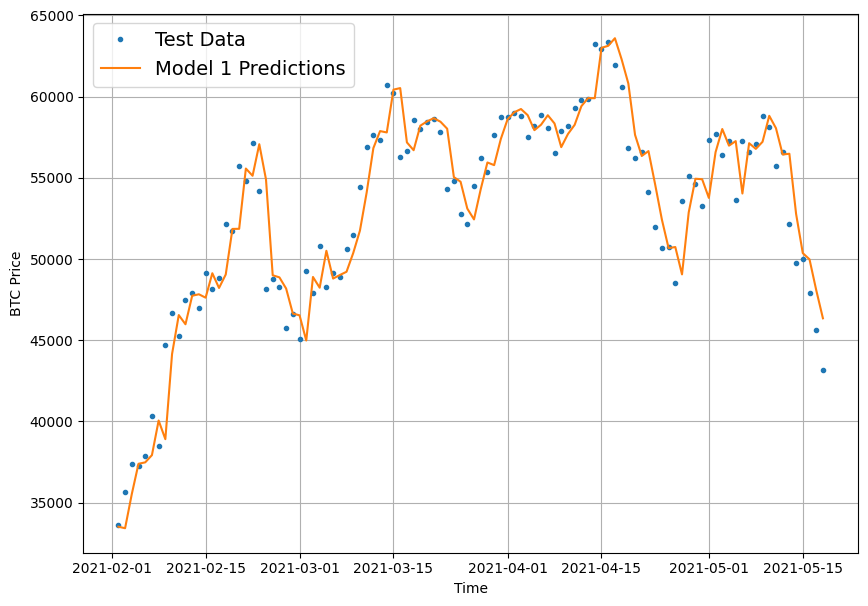

In [43]:
# Plot model_1 predictions
offset = 450
plt.figure(figsize=(10,7))
# Account for the test window offset and index into test_labels to ensure correct plotting
plot_time_series(timesteps=X_test[-len(test_windows):], values=tf.squeeze(test_labels), start=offset, label="Test Data") # instead of instead we can use test_labels[:,0]
plot_time_series(timesteps=X_test[-len(test_windows):], values=model_1_preds, start=offset, format="-", label="Model 1 Predictions")

Why is the model predictions lagged slightly behind the true labels?
-> Autocorrelation: https://otexts.com/fpp3/acf.html

## Model 2: Dense (window = 30, horizon = 1)



In [44]:
HORIZON = 1
WINDOW_SIZE = 30

In [45]:
# Make windowed data with appropriate horizon and window size
full_windows, full_labels = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows), len(full_labels)

[[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
  24 25 26 27 28 29 30]]
[[   0    1    2 ...   28   29   30]
 [   1    2    3 ...   29   30   31]
 [   2    3    4 ...   30   31   32]
 ...
 [2754 2755 2756 ... 2782 2783 2784]
 [2755 2756 2757 ... 2783 2784 2785]
 [2756 2757 2758 ... 2784 2785 2786]]


(2757, 2757)

In [46]:
# Make train and testing windows
train_windows, test_windows, train_labels, test_labels = make_train_test_split(full_windows, full_labels)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(2205, 552, 2205, 552)

In [47]:
train_windows[:3], train_labels[:3]

(array([[123.65499, 125.455  , 108.58483, 118.67466, 121.33866, 120.65533,
         121.795  , 123.033  , 124.049  , 125.96116, 125.27966, 125.9275 ,
         126.38333, 135.24199, 133.20333, 142.76333, 137.92333, 142.95166,
         152.55183, 160.33883, 164.31499, 177.63333, 188.29716, 200.70166,
         180.355  , 175.03166, 177.6965 , 187.15983, 192.75666, 197.4    ],
        [125.455  , 108.58483, 118.67466, 121.33866, 120.65533, 121.795  ,
         123.033  , 124.049  , 125.96116, 125.27966, 125.9275 , 126.38333,
         135.24199, 133.20333, 142.76333, 137.92333, 142.95166, 152.55183,
         160.33883, 164.31499, 177.63333, 188.29716, 200.70166, 180.355  ,
         175.03166, 177.6965 , 187.15983, 192.75666, 197.4    , 196.02499],
        [108.58483, 118.67466, 121.33866, 120.65533, 121.795  , 123.033  ,
         124.049  , 125.96116, 125.27966, 125.9275 , 126.38333, 135.24199,
         133.20333, 142.76333, 137.92333, 142.95166, 152.55183, 160.33883,
         164.31499, 177

In [48]:
tf.random.set_seed(42)

model_2 = tf.keras.Sequential([
    layers.Dense(128, activation="relu"),
    layers.Dense(HORIZON, activation="linear")
], name = "model_2_dense")

model_2.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())

model_2.fit(x=train_windows,
            y=train_labels,
            epochs=100,
            batch_size=128,
            verbose=0,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_2.name)])

In [49]:
# Evaluate model 2 on test data
model_2.evaluate(test_windows, test_labels)

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 459.4800 


839.4823608398438

In [50]:
# Load in the best performing model
model_2 = tf.keras.models.load_model("/content/model_experiments/model_2_dense.keras")
model_2.evaluate(test_windows, test_labels)

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 315.0945 


615.5819091796875

In [51]:
# Get forecast predictions
model_2_preds = make_preds(model_2, input_data=test_windows)

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


In [52]:
# Evaluate results for model 2 predictions
model_2_results = evaluate_pred(y_true=tf.squeeze(test_labels),
                                y_pred=model_2_preds)
model_2_results

{'mae': 615.5819,
 'mse': 1281325.9,
 'rmse': 1131.9567,
 'mape': 2.8108323,
 'mase': 1.0760431}

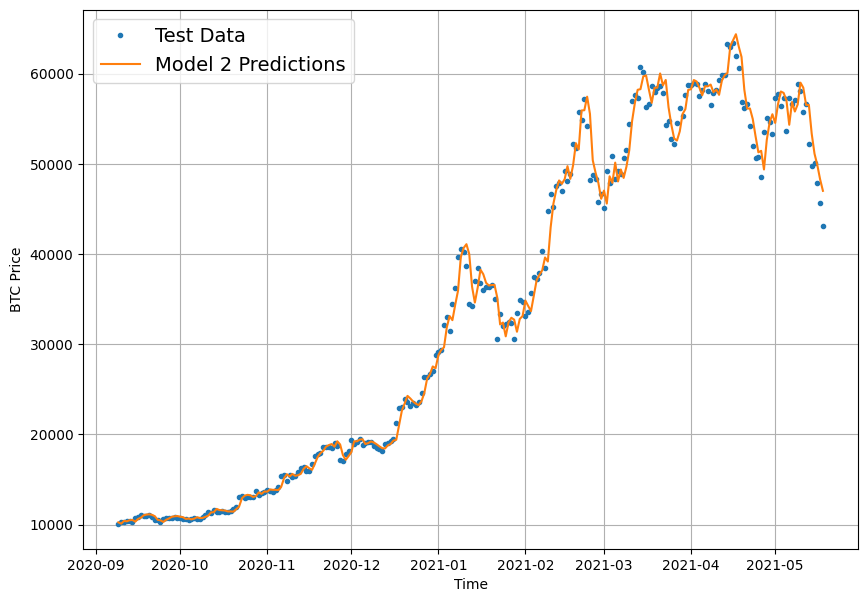

In [53]:
offset = 300
plt.figure(figsize=(10,7))
plot_time_series(timesteps=X_test[-len(test_windows):], values=tf.squeeze(test_labels), start=offset, label="Test Data")
plot_time_series(timesteps=X_test[-len(test_windows):], values=model_2_preds, start=offset, format="-", label="Model 2 Predictions")

## Model 3: Dense (window = 30, horizon = 7)

In [54]:
HORIZON = 7
WINDOW_SIZE = 30

full_windows, full_labels = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows), len(full_labels)

[[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
  24 25 26 27 28 29 30 31 32 33 34 35 36]]
[[   0    1    2 ...   34   35   36]
 [   1    2    3 ...   35   36   37]
 [   2    3    4 ...   36   37   38]
 ...
 [2748 2749 2750 ... 2782 2783 2784]
 [2749 2750 2751 ... 2783 2784 2785]
 [2750 2751 2752 ... 2784 2785 2786]]


(2751, 2751)

In [55]:
train_windows, test_windows, train_labels, test_labels = make_train_test_split(full_windows, full_labels)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(2200, 551, 2200, 551)

In [56]:
tf.random.set_seed(42)

model_3 = tf.keras.Sequential([
    layers.Dense(128, activation="relu"),
    layers.Dense(HORIZON, activation="linear")
], name="model_3_dense")

model_3.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())

model_3.fit(x=train_windows,
            y=train_labels,
            batch_size=128,
            epochs=100,
            verbose=0,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_3.name)])

In [57]:
# Evaluate the model on test data
model_3.evaluate(test_windows, test_labels)

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 636.6069 


1252.713134765625

In [58]:
# Load in the best performing model
model_3 = tf.keras.models.load_model("/content/model_experiments/model_3_dense.keras")
model_3.evaluate(test_windows, test_labels)

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 629.5772  


1251.1937255859375

In [59]:
# Create forecast predictions
model_3_preds = make_preds(model_3, test_windows)
model_3_preds[:5]

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


<tf.Tensor: shape=(5, 7), dtype=float32, numpy=
array([[9340.374, 9365.693, 9378.811, 9383.308, 9613.583, 9603.933,
        9405.053],
       [8865.193, 9064.78 , 9106.065, 9098.801, 9238.512, 9296.055,
        9021.192],
       [8708.522, 8932.101, 8894.348, 8821.035, 8939.094, 8841.495,
        8817.031],
       [8903.479, 9139.602, 9067.824, 8889.407, 8822.773, 8783.768,
        8913.249],
       [9020.734, 9035.866, 8979.512, 8720.645, 8696.981, 8686.432,
        8777.094]], dtype=float32)>

In [60]:
# Evaluate model_3 results
model_3_results = evaluate_pred(y_true=tf.squeeze(test_labels),
                                y_pred=model_3_preds)
model_3_results # we need to condense these array into single values

{'mae': array([ 648.3213  ,  352.0887  ,  252.70647 ,  304.84848 ,  290.9756  ,
         356.14557 ,  505.1691  ,  651.277   ,  674.64655 ,  705.5304  ,
         810.55084 ,  767.8024  ,  785.4365  ,  852.22107 ,  679.11395 ,
         329.31265 ,  229.44295 ,  260.72586 ,  266.56918 ,  307.68716 ,
          89.82708 ,  116.70459 ,  229.32973 ,  309.3337  ,  187.48389 ,
         135.70361 ,  134.19754 ,   84.44999 ,  103.83503 ,  195.60756 ,
         342.4025  ,  347.3157  ,  369.93344 ,  320.06564 ,  269.39615 ,
         241.70047 ,  279.3443  ,  266.49185 ,  196.45076 ,  187.06892 ,
         392.19427 ,   94.157715,   82.654015,   63.217773,   73.96345 ,
         114.330215,   97.17327 ,   88.36796 ,   91.13002 ,  111.222305,
         111.155556,  122.97001 ,  143.76814 ,  235.58377 ,  253.066   ,
         330.97922 ,  534.0062  ,  600.5005  ,  528.8011  ,  613.83154 ,
         459.11984 ,  252.80734 ,  282.21463 ,  399.66043 ,  414.782   ,
         530.6164  ,  542.68243 ,  561.1168 

In [61]:
model_2_preds.shape, model_3_preds.shape, model_2_results["mae"].shape, model_3_results["mae"].shape

(TensorShape([552]), TensorShape([551, 7]), (), (551,))

## Make our evaluation function work for larger horizons

In [62]:
# Create a function to take in model predictions and truth values and return evaluation metrics
def evaluate_pred(y_true, y_pred):
  # Make sure float32 datatype (for metric calculation)
  y_true = tf.cast(y_true, dtype=tf.float32)
  y_pred = tf.cast(y_pred, dtype=tf.float32)

  # Calculate various evaluation metrics
  mae = tf.keras.metrics.mae(y_true, y_pred)
  mse = tf.keras.metrics.mse(y_true, y_pred)
  rmse = tf.sqrt(mse)
  mape = tf.keras.metrics.mape(y_true, y_pred)
  mase = mean_absolute_scaled_error(y_true, y_pred)

  # Account for different sized metrics (for longer horizons, we want to reduce metrics to a single value)
  if mae.ndim > 0:
    mae = tf.reduce_mean(mae)
    mse = tf.reduce_mean(mse)
    rmse = tf.reduce_mean(rmse)
    mape = tf.reduce_mean(mape)
    mase = tf.reduce_mean(mase)

  return {"mae": mae.numpy(),
          "mse": mse.numpy(),
          "rmse": rmse.numpy(),
          "mape": mape.numpy(),
          "mase": mase.numpy()}

In [63]:
# Get model 3 results aggregated to single values
model_3_results = evaluate_pred(y_true=tf.squeeze(test_labels),
                                y_pred=model_3_preds)
model_3_results, naive_results

({'mae': 1251.1938,
  'mse': 5462298.5,
  'rmse': 1442.6998,
  'mape': 5.617991,
  'mase': 2.2264292},
 {'mae': 567.9802,
  'mse': 1147547.0,
  'rmse': 1071.2362,
  'mape': 2.5165248,
  'mase': 0.99957})

With model 3, we are trying to predict further into the future. This explains why the model prediction has higher losses.

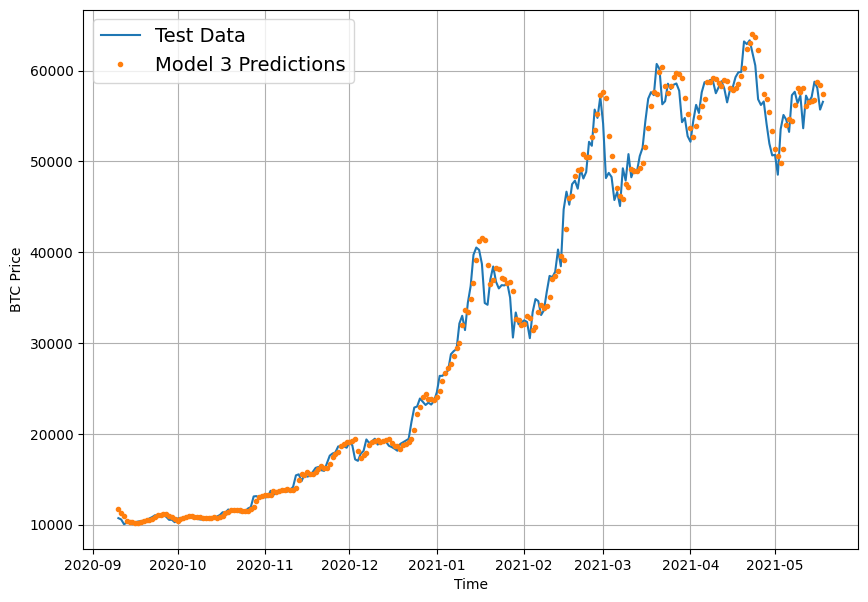

In [64]:
offset = 300
plt.figure(figsize=(10,7))
plot_time_series(timesteps=X_test[-len(test_windows):], values=test_labels[:,0], start=offset, format="-", label="Test Data")
plot_time_series(timesteps=X_test[-len(test_windows):], values=tf.reduce_mean(model_3_preds, axis=1), start=offset, label="Model 3 Predictions")

# We actually lost some informations because we reducing the seven days prediction into a single value

## Comparing the models so far

<Axes: >

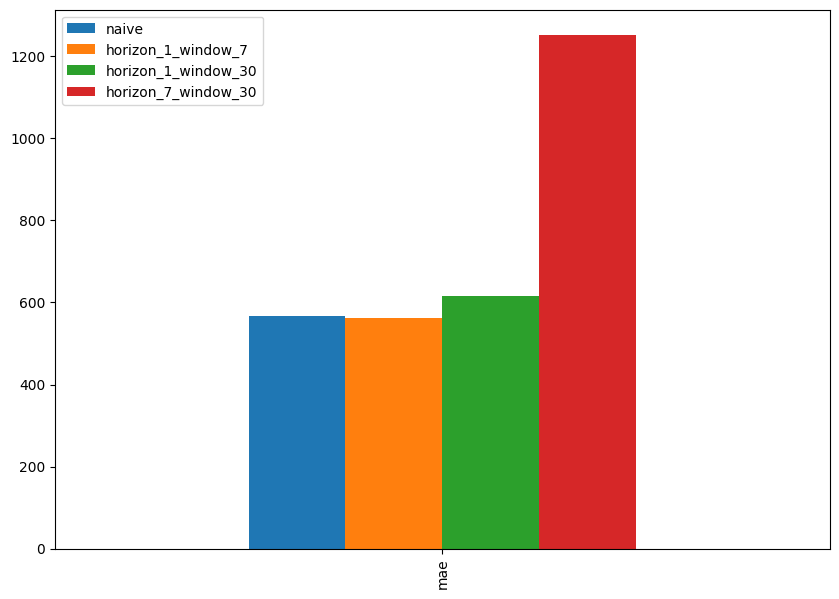

In [65]:
pd.DataFrame({"naive": naive_results["mae"],
              "horizon_1_window_7": model_1_results["mae"],
              "horizon_1_window_30": model_2_results["mae"],
              "horizon_7_window_30": model_3_results["mae"]}, index=["mae"]).plot(figsize=(10,7), kind="bar")

Why do our naive model did so good in comparison with complexer deep learning model? One of the reason its because the present of autocorrelation in the data. It means the value on this timestep is typically close to the value on the previous timestep. The naive model did good because of high autocorrelation and it is also hinting that our Bitcoin data has high autocorrelation.

**Resource:** https://medium.com/towards-data-science/how-not-to-use-machine-learning-for-time-series-forecasting-avoiding-the-pitfalls-19f9d7adf424

## Model 4: Conv1D

In [66]:
HORIZON = 1
WINDOW_SIZE = 7

In [67]:
# Create the window dataset (the same with model_1)
full_windows, full_labels = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows), len(full_labels)

[[0 1 2 3 4 5 6 7]]
[[   0    1    2 ...    5    6    7]
 [   1    2    3 ...    6    7    8]
 [   2    3    4 ...    7    8    9]
 ...
 [2777 2778 2779 ... 2782 2783 2784]
 [2778 2779 2780 ... 2783 2784 2785]
 [2779 2780 2781 ... 2784 2785 2786]]


(2780, 2780)

In [68]:
# Create train/test sets
train_windows, test_windows, train_labels, test_labels = make_train_test_split(full_windows, full_labels)
len(train_windows), len(train_labels), len(test_windows), len(train_labels)

(2224, 2224, 556, 2224)

To use the Conv1D layer, we need an input shape of: `(batch_size, timesteps, input_dim)`.

**Resource:** https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv1D

In [69]:
# Before our pass our data to the Conv1D layer, we have to reshape it
x = tf.constant(train_windows[0])
x

<tf.Tensor: shape=(7,), dtype=float64, numpy=
array([123.65499, 125.455  , 108.58483, 118.67466, 121.33866, 120.65533,
       121.795  ])>

In [70]:
expand_dims_layer = layers.Lambda(lambda x: tf.expand_dims(x, axis=1)) # add an extra dimension

In [71]:
# Test out our lambda layer
print(f"Original shape: {x.shape}") # WINDOW_SIZE
print(f"Expanded shape: {expand_dims_layer(x).shape}")
print(f"Original values with expanded shape:\n {expand_dims_layer(x)}")

Original shape: (7,)
Expanded shape: (7, 1)
Original values with expanded shape:
 [[123.65499]
 [125.455  ]
 [108.58483]
 [118.67466]
 [121.33866]
 [120.65533]
 [121.795  ]]


In [72]:
def expand_dims(x):
  return tf.expand_dims(x, axis=1)

In [73]:
tf.random.set_seed(42)

model_4 = tf.keras.Sequential([
    # layers.Lambda(lambda x: tf.expand_dims(x, axis=1)), # must create a separate function instead of a lambda function in order to reload the model safely
    layers.Lambda(expand_dims),
    layers.Conv1D(filters=128, kernel_size=5, strides=1, padding="causal", activation="relu"),
    layers.Dense(HORIZON)
], name="model_4_conv1d")

model_4.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())

model_4.fit(train_windows,
            train_labels,
            batch_size=128,
            epochs=100,
            verbose=0,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_4.name)])

In [74]:
model_4.summary()

Model: "model_4_conv1d"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lambda_1 (Lambda)                    │ (None, 1, 7)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d (Conv1D)                      │ (None, 1, 128)              │           4,608 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 1, 1)                │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,213 (55.52 KB)

 Trainable params: 4,737 (18.50 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 9,476 (37.02 KB)

In [75]:
# Evaluate model
model_4.evaluate(test_windows, test_labels)

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 288.3306 


575.9835205078125

In [76]:
# Load in best performing model and re-evaluate
model_4 = tf.keras.models.load_model("/content/model_experiments/model_4_conv1d.keras", custom_objects={'expand_dims': expand_dims})
model_4.evaluate(test_windows, test_labels)

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 284.7947  


568.0755004882812

In [77]:
# Make predictions
model_4_preds = make_preds(model_4, test_windows)
model_4_preds[:10]

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([8842.853, 8771.891, 9024.558, 8770.176, 8717.597, 8721.54 ,
       8670.83 , 8504.079, 8446.85 , 8514.715], dtype=float32)>

In [78]:
# Evaluate predictions
model_4_results = evaluate_pred(y_true=tf.squeeze(test_labels),
                                y_pred=model_4_preds)
model_4_results

{'mae': 568.07544,
 'mse': 1163736.9,
 'rmse': 1078.7664,
 'mape': 2.561875,
 'mase': 0.9979512}

## Model 5: RNN (LSTM)

In [79]:
tf.random.set_seed(42)

# Let's build the LSTM model with the Functional API
inputs = layers.Input(shape=(WINDOW_SIZE,))
x = layers.Lambda(expand_dims)(inputs)
#x = layers.LSTM(128, return_sequences=True)(x)
x = layers.LSTM(128, activation="relu")(x)
#x = layers.Dense(32, activation="relu")(x)
output = layers.Dense(HORIZON)(x)
model_5 = tf.keras.Model(inputs=inputs, outputs=output, name="model_5_lstm")

model_5.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())

model_5.fit(train_windows,
            train_labels,
            epochs=100,
            verbose=1,
            batch_size=128,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_5.name)])

Epoch 1/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 2954.7480 - val_loss: 12384.9082
Epoch 2/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 1555.4379 - val_loss: 2154.0229
Epoch 3/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 280.3640 - val_loss: 1054.0021
Epoch 4/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 196.8733 - val_loss: 1046.8350
Epoch 5/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 186.2672 - val_loss: 1088.2612
Epoch 6/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 180.6891 - val_loss: 1083.7588
Epoch 7/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 179.3337 - val_loss: 1071.3640
Epoch 8/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 177.7645 - val_loss: 1055.9843
Epoch 9/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 176.2416 - val_loss: 1044.6101
Epoch 10/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 174.5658 - val_loss: 1030.0913
Epoch 11/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 173.2876 - val_loss: 1020.

In [80]:
# Load in best performing model and evaluate
model_5 = tf.keras.models.load_model("/content/model_experiments/model_5_lstm.keras", custom_objects={'expand_dims': expand_dims})
model_5.evaluate(test_windows, test_labels)

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 291.5572  


580.9904174804688

In [81]:
# Make predictions
model_5_preds = make_preds(model_5, test_windows)
model_5_preds[:10]

18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step


<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([8922.306 , 8817.243 , 9009.7705, 8794.116 , 8742.96  , 8760.798 ,
       8691.132 , 8553.863 , 8477.096 , 8526.456 ], dtype=float32)>

In [82]:
# Evaluate predictions
model_5_results = evaluate_pred(y_true=tf.squeeze(test_labels),
                                y_pred=model_5_preds)
model_5_results

{'mae': 580.9904,
 'mse': 1219887.6,
 'rmse': 1104.4852,
 'mape': 2.6088924,
 'mase': 1.0206393}

In [83]:
model_1_results

{'mae': 562.7361,
 'mse': 1154880.6,
 'rmse': 1074.6537,
 'mape': 2.5205467,
 'mase': 0.98857147}

> **Note:** Because neural networks are such powerful algorithms, they can be used for almost any problem, however, that doesn't mean they'll achieve performant or usable results.

## Make a multivariate time series dataset

What other feature can we use? A feature that influence the price of Bitcoin.

How about the Bitcoin halving events?

**Resource:** https://www.investopedia.com/terms/b/block-reward.asp

In [84]:
# Add Bitcoin halving events into our dataset
block_reward_1 = 50 # 3 January 2009 - this block reward isn't in our dataset (our data starts on 1 October 2013)
block_reward_2 = 25 # 8 November 2012
block_reward_3 = 12.5 # 9 July 2016
block_reward_4 = 6.25 # 18 May 2020

# Block reward dates
block_reward_2_datetime = np.datetime64("2012-11-28")
block_reward_3_datetime = np.datetime64("2016-07-09")
block_reward_4_datetime = np.datetime64("2020-05-18")

In [85]:
# Create date range of where specifis block_reward values should be
block_reward_2_days = (block_reward_3_datetime - bitcoin_prices.index[0]).days
block_reward_3_days = (block_reward_4_datetime - bitcoin_prices.index[0]).days

In [86]:
# Add in block_reward column
bitcoin_prices_block = bitcoin_prices.copy()
bitcoin_prices_block["block_reward"] = None

In [87]:
# Add in block_reward values as a feature to our dataframe
bitcoin_prices_block.iloc[:block_reward_2_days, -1] = block_reward_2
bitcoin_prices_block.iloc[block_reward_2_days:block_reward_3_days, -1] = block_reward_3
bitcoin_prices_block.iloc[block_reward_3_days:, -1] = block_reward_4

In [88]:
bitcoin_prices_block.tail()

,Price,block_reward
Date,,
2021-05-14,49764.132082,6.25
2021-05-15,50032.693137,6.25
2021-05-16,47885.625255,6.25
2021-05-17,45604.615754,6.25
2021-05-18,43144.471291,6.25


<Axes: xlabel='Date'>

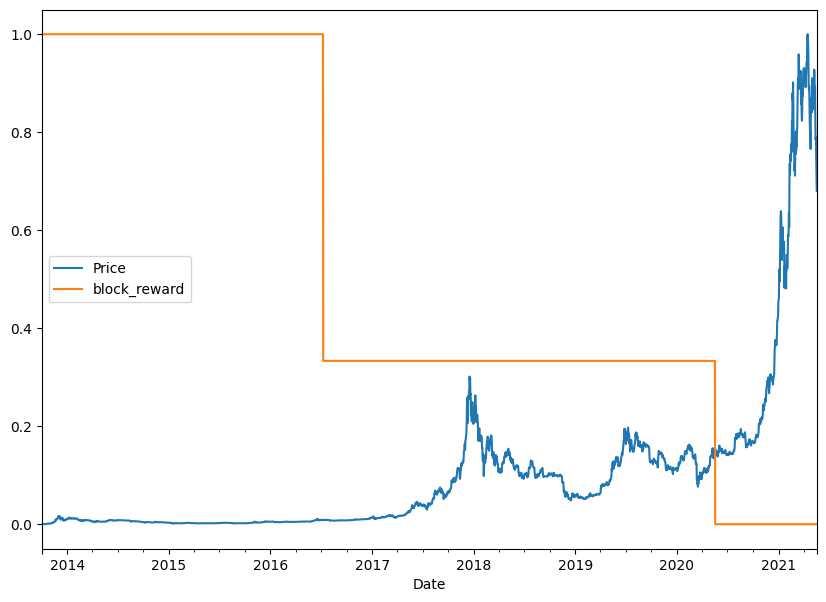

In [89]:
# Plot the block reward vs price overtime
from sklearn.preprocessing import minmax_scale
scaled_prices_block_df = pd.DataFrame(minmax_scale(bitcoin_prices_block[["Price", "block_reward"]]),
                                      columns = bitcoin_prices_block.columns,
                                      index=bitcoin_prices_block.index)
scaled_prices_block_df.plot(figsize=(10,7))

## Making a windowed dataset with pandas

Previously, we've turned ouw univariate time series into windowes dataset using the helper functions above. However, since we got multivariate data, these functions won't work.

We will use the `pandas.DataFrame.shift()` method to windows our multivariate data.

**Resource:** https://pandas.pydata.org/pandas-docs/dev/reference/api/pandas.DataFrame.shift.html

In [90]:
# Setup dataset hyperparameters
HORIZON = 1
WINDOW_SIZE = 7

In [91]:
# Make a copy of Bitcoin historical data with block reward feature
bitcoin_prices_windowed = bitcoin_prices_block.copy()

# Add windowed columns
for i in range(WINDOW_SIZE):
  bitcoin_prices_windowed[f"Price+{i+1}"] = bitcoin_prices_windowed["Price"].shift(periods=i+1) # shift value for each step in WINDOW_SIZE
bitcoin_prices_windowed.head(10)

,Price,block_reward,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,,
2013-10-01,123.65499,25,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-10-02,125.45500,25,123.65499,NaN,NaN,NaN,NaN,NaN,NaN
2013-10-03,108.58483,25,125.45500,123.65499,NaN,NaN,NaN,NaN,NaN
2013-10-04,118.67466,25,108.58483,125.45500,123.65499,NaN,NaN,NaN,NaN
2013-10-05,121.33866,25,118.67466,108.58483,125.45500,123.65499,NaN,NaN,NaN
2013-10-06,120.65533,25,121.33866,118.67466,108.58483,125.45500,123.65499,NaN,NaN
2013-10-07,121.79500,25,120.65533,121.33866,118.67466,108.58483,125.45500,123.65499,NaN
2013-10-08,123.03300,25,121.79500,120.65533,121.33866,118.67466,108.58483,125.45500,123.65499
2013-10-09,124.04900,25,123.03300,121.79500,120.65533,121.33866,118.67466,108.58483,125.45500


In [92]:
bitcoin_prices_windowed.tail()

,Price,block_reward,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,,
2021-05-14,49764.132082,6.25,52147.821187,56573.555472,55715.546651,58102.191426,58788.209679,57107.120672,56583.849879
2021-05-15,50032.693137,6.25,49764.132082,52147.821187,56573.555472,55715.546651,58102.191426,58788.209679,57107.120672
2021-05-16,47885.625255,6.25,50032.693137,49764.132082,52147.821187,56573.555472,55715.546651,58102.191426,58788.209679
2021-05-17,45604.615754,6.25,47885.625255,50032.693137,49764.132082,52147.821187,56573.555472,55715.546651,58102.191426
2021-05-18,43144.471291,6.25,45604.615754,47885.625255,50032.693137,49764.132082,52147.821187,56573.555472,55715.546651


We created a way to window our dataset directly from a pandas dataframe.

```
[0, 1, 2, 3, 4, 5, 6, block_reward] -> [7]
[1, 2, 3, 4, 5, 6, 7, block_reward] -> [8]
[2, 3, 4, 5, 6, 7, 8, block_reward] -> [9]
```

In [93]:
# Create X (windows) and y (horizons) features
X = bitcoin_prices_windowed.dropna().drop("Price", axis=1).astype(np.float32)
y = bitcoin_prices_windowed.dropna()["Price"].astype(np.float32)

In [94]:
X.head()

,block_reward,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,
2013-10-08,25.0,121.794998,120.655327,121.338661,118.674660,108.584831,125.455002,123.654991
2013-10-09,25.0,123.032997,121.794998,120.655327,121.338661,118.674660,108.584831,125.455002
2013-10-10,25.0,124.049004,123.032997,121.794998,120.655327,121.338661,118.674660,108.584831
2013-10-11,25.0,125.961159,124.049004,123.032997,121.794998,120.655327,121.338661,118.674660
2013-10-12,25.0,125.279663,125.961159,124.049004,123.032997,121.794998,120.655327,121.338661


In [95]:
y.head()

,Price
Date,
2013-10-08,123.032997
2013-10-09,124.049004
2013-10-10,125.961159
2013-10-11,125.279663
2013-10-12,125.927498


In [96]:
# Make train and test set using indexing
split_size = int(len(X) * 0.8)
X_train, y_train = X[:split_size], y[:split_size]
X_test, y_test = X[split_size:], y[split_size:]
len(X_train), len(y_train), len(X_test), len(y_test)

(2224, 2224, 556, 556)

## Model 6: Dense (multivariate time series)

In [97]:
tf.random.set_seed(42)

model_6 = tf.keras.Sequential([
    layers.Dense(128, activation="relu"),
    layers.Dense(HORIZON)
], name="model_6_dense_multivariate")

model_6.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())

model_6.fit(X_train,
            y_train,
            epochs=100,
            verbose=1,
            validation_data=(X_test, y_test),
            callbacks=[create_model_checkpoint(model_name=model_6.name)])

Epoch 1/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1249.7410 - val_loss: 1055.3657
Epoch 2/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 160.6418 - val_loss: 940.5721
Epoch 3/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 154.8446 - val_loss: 951.4828
Epoch 4/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 151.7282 - val_loss: 792.3201
Epoch 5/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 136.2199 - val_loss: 731.5527
Epoch 6/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 132.4196 - val_loss: 694.4768
Epoch 7/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 133.1996 - val_loss: 678.6495
Epoch 8/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 126.7713 - val_loss: 750.1799
Epoch 9/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 123.8468 - val_loss: 695.7344
Epoch 10/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 121.4290 - val_loss: 679.2859
Epoch 11/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 123.0869 - val_loss: 857.0226
Epoch 12/100
70/7

In [98]:
# Evaluate multivariate model
model_6.evaluate(X_test, y_test)

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 282.0971 


566.1111450195312

In [99]:
# Load in and evaluate best performing model
model_6 = tf.keras.models.load_model("/content/model_experiments/model_6_dense_multivariate.keras")
model_6.evaluate(X_test, y_test)

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 281.7233  


564.8605346679688

In [100]:
# Make predictions with multivariate model
model_6_preds = tf.squeeze(model_6.predict(X_test))
model_6_preds[:10]

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([8823.683, 8762.675, 9050.987, 8764.302, 8731.753, 8738.702,
       8680.544, 8498.55 , 8458.267, 8527.556], dtype=float32)>

In [101]:
# Evaluate the predictions
model_6_results = evaluate_pred(y_true=y_test,
                                y_pred=model_6_preds)
model_6_results

{'mae': 564.86053,
 'mse': 1145494.5,
 'rmse': 1070.2777,
 'mape': 2.5331903,
 'mase': 0.9923035}

## Model 7: N-BEATS algorithm

Replication the algorithm in Figure 1 from the following paper: https://arxiv.org/abs/1905.10437

### Building and testing the N-BEATS block layer

Because the N-BEATS block layer doesn't exist in TensorFlow, we've got to create it.

To create custom layers and models in TensorFlow we can use subclassing:
https://www.tensorflow.org/guide/keras/making_new_layers_and_models_via_subclassing

In [102]:
# Create NBeatBlock custom layer (the input is the windows and output are backcast and forecast)
class NBeatsBlock(tf.keras.layers.Layer):
  def __init__(self,
               input_size: int,
               theta_size: int,
               horizon: int,
               n_neurons: int,
               n_layers: int,
               **kwargs): # the **kwargs argument takes care of all the arguments for the parent class (e.g. input_shape, trainable, names, etc.)
    super().__init__(**kwargs)
    self.input_size = input_size
    self.theta_size = theta_size
    self.horizon = horizon
    self.n_neurons = n_neurons
    self.n_layers = n_layers

    # Block contains stack of 4 fully connected layers each has ReLU activation
    self.hidden = [tf.keras.layers.Dense(n_neurons, activation="relu") for _ in range(n_layers)]
    # Output of block is a theta layer with linear activation
    self.theta_layer = tf.keras.layers.Dense(theta_size, activation="linear", name="theta")

  def call(self, inputs):
    x = inputs
    for layer in self.hidden:
      x = layer(x)
    theta = self.theta_layer(x)
    # Output the backcast and the forecast from theta
    backcast, forecast = theta[:, :self.input_size], theta[:, -self.horizon:]
    return backcast, forecast

Let's test the N-BEATS block class by making dummy inputs and outputs.

In [103]:
# Set up dummy NBeatsBlock layer to represent inputs and outputs
tf.random.set_seed(42)
dummy_nbeats_block_layer = NBeatsBlock(input_size=WINDOW_SIZE,
                                       theta_size=WINDOW_SIZE+HORIZON, #backcast + forecast
                                       horizon=HORIZON,
                                       n_neurons=128,
                                       n_layers=4)

In [104]:
# Create dummy inputs (have to be same size as input_size)
dummy_inputs = tf.expand_dims(tf.range(WINDOW_SIZE)+1, axis=0) # input shape to the model has to reflect dense layer input requirements (ndim=2)
dummy_inputs

<tf.Tensor: shape=(1, 7), dtype=int32, numpy=array([[1, 2, 3, 4, 5, 6, 7]], dtype=int32)>

In [105]:
# Pass dummy inputs to dummy NBeatsBlock layer
backcast, forecast = dummy_nbeats_block_layer(dummy_inputs)
# These are the activation output of the theta layer (they'll be random due to no training of the model)
print(f"Backcast: {tf.squeeze(backcast.numpy())}")
print(f"Forecast: {tf.squeeze(forecast.numpy())}")


Backcast: [ 0.18387899  1.6708345  -0.14180784 -0.57385796  1.4873195   0.77404165
 -0.880221  ]
Forecast: -0.5382110476493835


## Preparing data for the N-BEATS algorithm using `tf.data`.

To make out input data load as fast as possible we're going to be adhering to the performant data pipeline steps in the tf.data guide: https://www.tensorflow.org/guide/data_performance

In [106]:
HORIZON = 1
WINDOW_SIZE = 7

In [107]:
# Create N-BEATS data inputs (N-BEATS works with univariate time series)
# Add windowed columns
bitcoin_prices_nbeats = bitcoin_prices.copy()
for i in range(WINDOW_SIZE):
  bitcoin_prices_nbeats[f"Price+{i+1}"] = bitcoin_prices_nbeats["Price"].shift(periods=i+1)
bitcoin_prices_nbeats.head(10)

,Price,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,
2013-10-01,123.65499,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-10-02,125.45500,123.65499,NaN,NaN,NaN,NaN,NaN,NaN
2013-10-03,108.58483,125.45500,123.65499,NaN,NaN,NaN,NaN,NaN
2013-10-04,118.67466,108.58483,125.45500,123.65499,NaN,NaN,NaN,NaN
2013-10-05,121.33866,118.67466,108.58483,125.45500,123.65499,NaN,NaN,NaN
2013-10-06,120.65533,121.33866,118.67466,108.58483,125.45500,123.65499,NaN,NaN
2013-10-07,121.79500,120.65533,121.33866,118.67466,108.58483,125.45500,123.65499,NaN
2013-10-08,123.03300,121.79500,120.65533,121.33866,118.67466,108.58483,125.45500,123.65499
2013-10-09,124.04900,123.03300,121.79500,120.65533,121.33866,118.67466,108.58483,125.45500


In [108]:
# Make features and labels
X = bitcoin_prices_nbeats.dropna().drop("Price", axis=1)
y = bitcoin_prices_nbeats.dropna()["Price"]

# Make train and test sets
split_size = int(len(X) * 0.8)
X_train, y_train = X[:split_size], y[:split_size]
X_test, y_test = X[split_size:], y[split_size:]

len(X_train), len(y_train), len(X_test), len(y_test)

(2224, 2224, 556, 556)

In [109]:
# Time to make our dataset performant using tf.data API
train_features_dataset = tf.data.Dataset.from_tensor_slices(X_train)
train_labels_dataset = tf.data.Dataset.from_tensor_slices(y_train)

test_features_dataset = tf.data.Dataset.from_tensor_slices(X_test)
test_labels_dataset = tf.data.Dataset.from_tensor_slices(y_test)

# Combine labels and features by zipping together -> (features, labels)
train_dataset = tf.data.Dataset.zip((train_features_dataset, train_labels_dataset))
test_dataset = tf.data.Dataset.zip((test_features_dataset, test_labels_dataset))

# Batch and prefetch
BATCH_SIZE = 1024
train_dataset = train_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

train_dataset, test_dataset

(<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 7), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 7), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>)

### Setting up hyperparameters for N-BEATS algorithm

The N_BEATS algorithm has a fair few number of parameters, many of them can be found in Table 18: https://arxiv.org/pdf/1905.10437

In [110]:
# Values from N-BEATS paper
N_EPOCHS = 5000
N_NEURONS = 512
N_LAYERS = 4
N_STACKS = 30

INPUT_SIZE = WINDOW_SIZE * HORIZON
THETA_SIZE = INPUT_SIZE + HORIZON

INPUT_SIZE, THETA_SIZE

(7, 8)

### Getting ready for residual connections

Before we can craft our N-BEATS model, we need two layers for the residual connections (subtract and add).

The N-BEATS algorithmn uses double residual stacking to help train its deeper architecture (section 3.2 of N-BEATS paper).

For more on residual connections: https://paperswithcode.com/method/resnet

In [111]:
# Make tensors
tensor_1 = tf.range(10) + 10
tensor_2 = tf.range(10)

# Subtract
subtracted = layers.subtract([tensor_1, tensor_2])

# Add
added = layers.add([tensor_1, tensor_2])

# Outputs
print(f"Input tensor: {tensor_1.numpy()} & {tensor_2.numpy()}")
print(f"Subtracted: {subtracted.numpy()}")
print(f"Added: {added.numpy()}")

Input tensor: [10 11 12 13 14 15 16 17 18 19] & [0 1 2 3 4 5 6 7 8 9]
Subtracted: [10 10 10 10 10 10 10 10 10 10]
Added: [10 12 14 16 18 20 22 24 26 28]


### Building, compiling and fitting the N-BEATS algorithm

1. Setup an instance of the N-BEATS block layer using `NBeatsBlock` (this'll we be the initial block used for the network, the rest will be created as stacks).
2. Create an input layer for the N-BEATS stack (we'll be using the Keras Functional API).
3. Make the initial backcast and forecast for the model with the layer created in (1).
4. Use for loop to create stacks of block layers.
5. Use the `NBeatsBlock` class within the for loop in (4) to create blocks which returns backcasts and block-level forecasts.
6. Create the double residual stacking using subtract and add layers.
7. Put the model inputs and outputs together using `tf.keras.Model()`.
8. Compile the model with MAE loss (the paper uses multiple losses, but we'll use MAE to keep it inline with our other models) and Adam optimizer with default setting as per section 5.2 of N-BEATS paper.
9. Fit the N-BEATS model for 5000 epochs and use a couple of callbacks:
  * Early Stopping - because the model will be training for so long we'll stop it early if it stops improving.
  * Reduce LR on Plateau - if a model stops improving, try lowering the learning rate to reduce the amount it updates its weight each time (take smaller steps toward best performance).

In [ ]:
%%time

tf.random.set_seed(42)

# 1. Setup and instance of NBeatsBlock
nbeats_block_layer = NBeatsBlock(input_size=INPUT_SIZE,
                                 theta_size=THETA_SIZE,
                                 horizon=HORIZON,
                                 n_neurons=N_NEURONS,
                                 n_layers=N_LAYERS,
                                 name="InitialBlock")

# 2. Create input to stack
stack_input = layers.Input(shape=(INPUT_SIZE,), name="stack_input")

# 3. Create initial backcast and forecast input (backwards prediction + horizon prediction)
residuals, forecast = nbeats_block_layer(stack_input)

# 4. Create stacks of block layers
for i, _ in enumerate(range(N_STACKS-1)): # first stack is already created in (3)

  # 5. Use the NBeatsBlock to calculate the backcast and the forecast
  backcast, block_forecast = NBeatsBlock(
      input_size=INPUT_SIZE,
      theta_size=THETA_SIZE,
      horizon=HORIZON,
      n_neurons=N_NEURONS,
      n_layers=N_LAYERS,
      name=f"NBeatsBlock_{i}"
  )(residuals) # pass in the residuals

  # 6. Create the double residual stacking
  residuals = layers.subtract([residuals, backcast], name=f"subtract_{i}")
  forecast = layers.add([forecast, block_forecast], name=f"add_{i}")

# 7. Put the stack model together
model_7 = tf.keras.Model(inputs=stack_input,
                         outputs=forecast,
                         name="model_7_NBEATS")

# 8 Compile model with MAE loss
model_7.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())

# 9. Fit the model with EarlyStopping and ReduceLROnPlateau callbacks
model_7.fit(train_dataset,
            epochs=N_EPOCHS,
            validation_data=test_dataset,
            verbose=0,
            callbacks=[tf.keras.callbacks.EarlyStopping(monitor="val_loss",
                                                        patience=200,
                                                        restore_best_weights=True),
                       tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",
                                                            patience=100,
                                                            verbose=1)])

In [ ]:
# Evaluate N-BEATS model on the test dataset
model_7.evaluate(test_dataset)

In [ ]:
# Make predictions with N-BEATS model
model_7_preds = make_preds(model_7, test_dataset)
model_7_preds[:10]

In [ ]:
# Evaluate N-BEATS model preds
model_7_results = evaluate_pred(y_true=tf.squeeze(test_labels),
                                y_pred=model_7_preds)
model_7_results